# Explore bias-correction

This notebook served as the initial development environment for experimenting with bias adjustment of simulated GCM data using `xclim`.  In its final form, it now serves as a record of how we will go about developing our production bias-adjusted dataset. Note, one thing that was

With `xclim` we have at our disposal a number of different methods of adjustment, as well as multiple "knobs" to turn to tweak those methods. There is more functionality available than we have capacity for evaluating and finding a "best" method, and this could be the subject of a future project.

Rather, we will use [Lavoie et al 2024](https://doi.org/10.1038/s41597-023-02855-z) as a defensible template to follow. Given the publication (Scientific Data, a high-impact data journal under the Nature umbrella). The authors used detrended quantile mapping for the same variables we are planning to adjust (at least, initially): daily maximum temperature ($T_{max}$), daily minimum temperature ($T_{max}$), and precipitation ($Pr$). 

##### Bias-correction or bias-adjustment??

Lavoie et al 2024 almost exclusively use bias-**adjustment** in their article. However, most of the literature seems to use bias-**correction**. This pipeline will aim for internal consistency using "adjustment", given its prominence in the `xclim` framework ("train-adjust"), the fact that this is a newer paper and so might represent somewhat of an evolution, and "adjustment" feels better to [KR] than "correction" because we don't really know how "correct" the resulting data are.

## Bias-adjustment example

Here we will step through what we have learned in developing this workflow by performing a bias-adjustment using the exact<sup>*</sup> method we plan to implement for all input data. 



<sup>*</sup> The one difference between adjusting $Pr$ and the other variables is that we will use a multiplicative adjustment instead of additive.

Load the libs:

(This notebook will make use of the `dask-jobqueue` to run this example on a Chinook compute node via slurmn)

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
from dask.distributed import Client
from xclim import units
from xclim.sdba.detrending import LoessDetrend
from dask_jobqueue import SLURMCluster

import dask

# we have to make some big chunks and this will silence a warning about that
dask.config.set(**{"array.slicing.split_large_chunks": False})

Directories for the prepped ERA5 and the regridded CMIP6 data:

In [2]:
# TO-DO: change to common dirs when available
era5_dir = Path("/import/beegfs/CMIP6/arctic-cmip6/era5/daily_regrid")
cmip6_dir = Path("/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid")
cmip6_tmp_fn = "{var_id}_day_{model}_{scenario}_regrid_{year}0101-{year}1231.nc"

log_dir = "."

Set up a slurm cluster and dask client:

In [3]:
# dunno really how to set this, but it works for now
cluster = SLURMCluster(
    cores=24,
    memory="128GB",
    queue="debug",
    # queue="t2small",
    walltime="01:00:00",
    log_directory=log_dir,
    account="cmip6",
    interface="ib0",
)

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.55.40.4:8787/status,
Dashboard: http://10.55.40.4:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.55.40.4:40049,Workers: 0
Dashboard: http://10.55.40.4:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Fire up the cluster:

In [5]:
cluster.scale(1)

We will aim to perform the adjustment using 1993-2022 as the reference period. This reference period is subject to change in the main pipeline, but it was chosen here because Lavoie et al 2024 simply chose the most recent 30-year period of available data at the time of development. We could potentially use 1994-2023 if we wanted to go even more recent, but that would require downloading extra ERA5 data.

Because this time period overlaps the dividing year between ScenarioMIP data and CMIP historical experiments, 2015, we will combine data from the two for performing the bias adjustment. This means we will eventually be recycling the simulated historical data of 1993-2014 for each future scenario for the production processing. 

We will execute a test run with $T_{max}$ for GFDL-ESM4, using the SSP5-8.5 scenario. Get the relevant filepaths:

In [6]:
# "tas" in ERA5 is t2m, so we have named the daily max version t2mmax
ref_var_id = "t2mmax"
ref_start_year = 1993
ref_end_year = 2022
ref_fps = [
    era5_dir.joinpath(ref_var_id).joinpath(f"era5_daily_regrid_{ref_var_id}_{year}.nc")
    for year in range(ref_start_year, ref_end_year + 1)
]


var_id = "tasmax"
model = "GFDL-ESM4"

hist_start_year = 1993
hist_end_year = 2014

hist_fps = [
    cmip6_dir.joinpath(
        model,
        "historical",
        "day",
        var_id,
        cmip6_tmp_fn.format(
            var_id=var_id, model=model, scenario="historical", year=year
        ),
    )
    for year in range(hist_start_year, hist_end_year + 1)
]

scenario = "ssp585"
sim_ref_start_year = 2015
sim_ref_end_year = 2022
sim_ref_fps = [
    cmip6_dir.joinpath(
        model,
        scenario,
        "day",
        var_id,
        cmip6_tmp_fn.format(var_id=var_id, model=model, scenario=scenario, year=year),
    )
    for year in range(sim_ref_start_year, sim_ref_end_year + 1)
]

Open the datasets from the yearly data files for each of ERA5 and CMIP6:

In [7]:
hist_ds = xr.open_mfdataset(hist_fps + sim_ref_fps)
# convert calendar to noleap to match CMIP6
ref_ds = xr.open_mfdataset(ref_fps).convert_calendar("noleap")

Sample plot check:

Text(0.5, 1.0, 'Historical simulated')

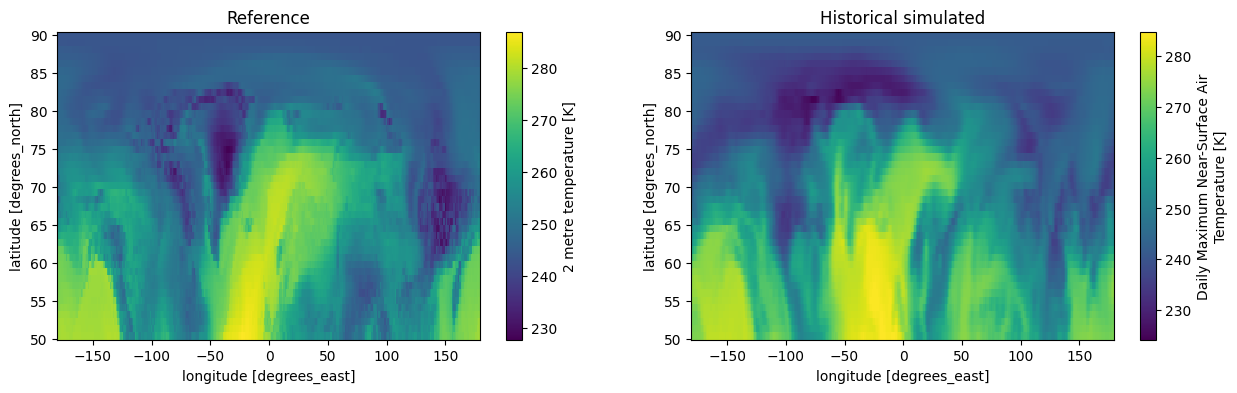

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ref_ds["t2mmax"].isel(time=1).plot(ax=axes[0])
axes[0].set_title("Reference")
hist_ds["tasmax"].isel(time=1).plot(ax=axes[1])
axes[1].set_title("Historical simulated")

Okay, here is a dask gotchya: you cannot use the training functions in `xclim.sdba` with datasets having chunks along the adjustment dimension (time in this case) so we need to rechunk it into one. We split it up into chunks over the lat and lon dims for some added optimization (hopefully).

We will also initialize the bias adjustment here. We are performing a "detrended" quantile mapping grouped by day of the year. To quote Lavoie et al 2024:

>The procedure is univariate (applied to each variable individually), acts independently on the trends and the anomalies, and is applied iteratively on each day of the year as well as at each grid point.

Other parameters can be seen below. Not sure what they all mean, but we are using 50 quantiles and a window of 31 days. specifying `d=0` uses "local constancy", meaning local estimates are weighted averages.

The final adjusted output will be stored in `scen`, which is currently just a dask task graph until we call `.compute()` on it, or need the data in some way.

In [9]:
ref = ref_ds["t2mmax"]
hist = hist_ds["tasmax"]
ref.data = ref.data.rechunk({0: -1, 1: 20, 2: 20})
hist.data = hist.data.rechunk({0: -1, 1: 20, 2: 20})

dqm = sdba.DetrendedQuantileMapping.train(
    ref, hist, nquantiles=50, group="time.dayofyear", window=31, kind="+"
)
# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")
scen = dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)

Then run it. It does take a long time to compute for the entire grid, so we can do it for a single pixel instead:

In [11]:
sel_di = {"lon": -147, "lat": 65}
scen = scen.sel(sel_di, method="nearest").compute()

Do some plotting to evaluate:

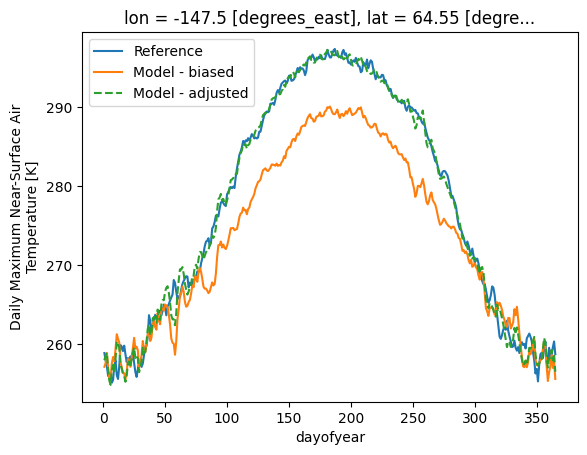

In [12]:
ref.sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Reference"
)
hist.sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Model - biased"
)
scen.groupby("time.dayofyear").mean().plot(label="Model - adjusted", linestyle="--")

plt.legend()

That is certainly an improvement!

## Bias-adjusting precipitation

Following Lavoie et al 2024, there is an additional piece for adjusting precipitation that we need to take into account. From their "Bias Adjustment of ESPO-G6-R2 v1.0.0" included in the [configuration repository](https://github.com/Ouranosinc/ESPO-G/blob/fbfc55c6378f009877ec35e58805b847d300d99b/documentation/ESPO_G6_R2v100_adjustment.pdf):

> when the model has a higher dry-day frequency than the reference, the calibration step of the quantile mapping adjustment will incorrectly map all dry days to precipitation days, resulting in a wet bias. The frequency adaptation method finds the fraction of ”extra” dry days

So we will try to implement this same frequency adaptation method.

Load some precip data:


In [ ]:
ref_var_id = "tp"
ref_start_year = 1993
ref_end_year = 2022
ref_fps = [
    era5_dir.joinpath(ref_var_id).joinpath(f"era5_daily_regrid_{ref_var_id}_{year}.nc")
    for year in range(ref_start_year, ref_end_year + 1)
]


var_id = "pr"
model = "GFDL-ESM4"

hist_start_year = 1993
hist_end_year = 2014

hist_fps = [
    cmip6_dir.joinpath(
        model,
        "historical",
        "day",
        var_id,
        cmip6_tmp_fn.format(
            var_id=var_id, model=model, scenario="historical", year=year
        ),
    )
    for year in range(hist_start_year, hist_end_year + 1)
]

scenario = "ssp585"
sim_ref_start_year = 2015
sim_ref_end_year = 2022
sim_ref_fps = [
    cmip6_dir.joinpath(
        model,
        scenario,
        "day",
        var_id,
        cmip6_tmp_fn.format(var_id=var_id, model=model, scenario=scenario, year=year),
    )
    for year in range(sim_ref_start_year, sim_ref_end_year + 1)
]

Open the datasets from the yearly data files for each of ERA5 and CMIP6:

In [ ]:
hist_ds = xr.open_mfdataset(hist_fps + sim_ref_fps)
# convert calendar to noleap to match CMIP6
# for some reason the precip data for 2022 has an expver variable while the t2m data doesnt
# drop this as it might be causing problems
ref_ds = (
    xr.open_mfdataset(ref_fps)
    .convert_calendar("noleap")
    .sel(expver=1)
    .drop_vars("expver")
)

Get the DataArrays and re-chunk:

In [ ]:
ref = ref_ds["tp"]
hist = hist_ds["pr"]
ref.data = ref.data.rechunk({0: -1, 1: 20, 2: 20})
hist.data = hist.data.rechunk({0: -1, 1: 20, 2: 20})

In [ ]:
ref.attrs["units"] = "m/d"

I think we need to set the units to `m d-1` so it is compatible with xclim's (`pint`'s) unit scheme (since these are at a daily time step):

In [ ]:
ref.attrs["units"] = "m d-1"

First we need to make sure there are no true 0's in the data, as this causes problems, as described in that document linked above. 
`xscen` uses `xclim`'s `sdba.processing.jitter_under_thresh` to accomplish this.

In [ ]:
ref = sdba.processing.jitter_under_thresh(ref, thresh="0.01 mm d-1")
hist = sdba.processing.jitter_under_thresh(hist, thresh="0.01 mm d-1")

Check it out:

In [ ]:
# select a subset of time range just for examination
before_jitter = ref_ds["tp"].isel(time=slice(100, 200)).compute()
after_jitter = ref.isel(time=slice(100, 200)).compute()

KeyboardInterrupt: 

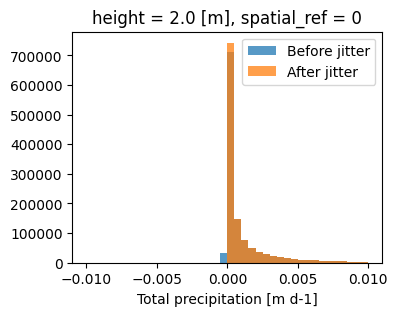

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

before_jitter.plot.hist(
    range=[-0.01, 0.01], alpha=0.75, bins=40, ax=ax, label="Before jitter"
)
after_jitter.plot.hist(
    range=[-0.01, 0.01], alpha=0.75, bins=40, ax=ax, label="After jitter"
)
plt.legend(loc="upper right")

plt.show()

You can see that there were some negative values in this model beforehand and those have been bounded at 0 and relace with random noise.

Now set up the training object:

In [ ]:
dqm = sdba.DetrendedQuantileMapping.train(
    ref=ref,
    hist=hist,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

Following along with `xscen` here:

In [ ]:
# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")
scen = dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)

Then run it. We can just run it for a single pixel to save some time:

In [ ]:
sel_di = {"lon": -147, "lat": 65}
scen1 = scen.sel(sel_di, method="nearest").compute()

Do some plotting to evaluate:

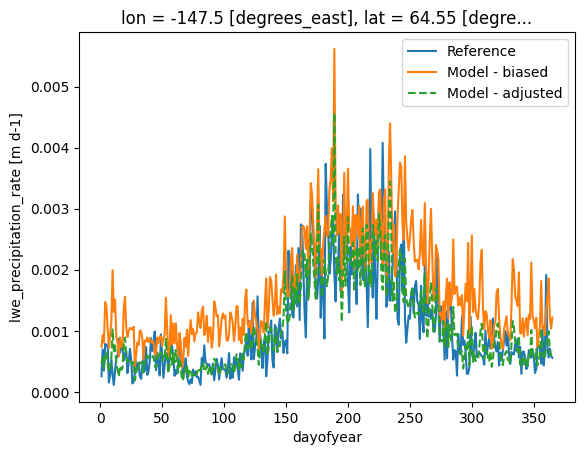

In [ ]:
ref.sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Reference"
)
units.convert_units_to(hist.sel(sel_di, method="nearest"), "m d-1").groupby(
    "time.dayofyear"
).mean().plot(label="Model - biased")
scen1.groupby("time.dayofyear").mean().plot(label="Model - adjusted", linestyle="--")

plt.legend()

That's actually tough to make sense of, although it does appear to be an improvement, with the adjusted data seemignly closer to the reference. Maybe monthly averages would be better to visualize this:

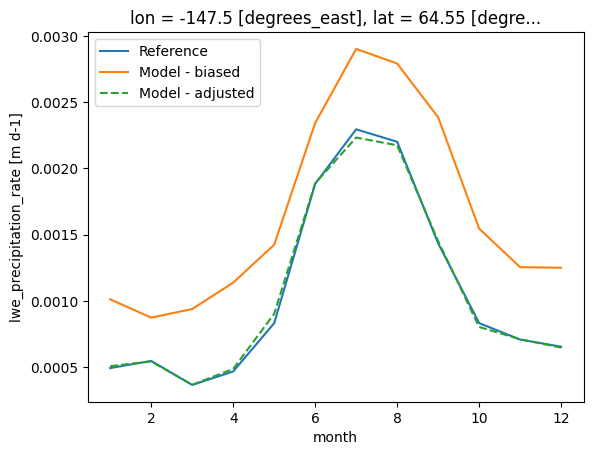

In [ ]:
sel_di = {"lon": -147, "lat": 65}
ref.sel(sel_di, method="nearest").groupby("time.month").mean().plot(label="Reference")
units.convert_units_to(hist.sel(sel_di, method="nearest"), "m d-1").groupby(
    "time.month"
).mean().plot(label="Model - biased")
scen1.groupby("time.month").mean().plot(label="Model - adjusted", linestyle="--")

plt.legend()

Yep, that's definitely an improvement!

#### Checking on some weirdness

Noticed some anomalous values in adjusted precipitation data during pipeline development, wanted to explore that here.


Noticed that latitude 63.61, longitude 178.8, and 2089-11-22 for MIROC6 ssp585 had some extremely high values for daily precip. Load that data in and do the same type of daily average time series comparison plot:


In [13]:
ref_var_id = "tp"
ref_start_year = 1993
ref_end_year = 2022
ref_fps = [
    era5_dir.joinpath(ref_var_id).joinpath(f"era5_daily_regrid_{ref_var_id}_{year}.nc")
    for year in range(ref_start_year, ref_end_year + 1)
]


var_id = "pr"
model = "MIROC6"

hist_start_year = 1993
hist_end_year = 2014

hist_fps = [
    cmip6_dir.joinpath(
        model,
        "historical",
        "day",
        var_id,
        cmip6_tmp_fn.format(
            var_id=var_id, model=model, scenario="historical", year=year
        ),
    )
    for year in range(hist_start_year, hist_end_year + 1)
]

scenario = "ssp585"
sim_ref_start_year = 2015
sim_ref_end_year = 2022
sim_ref_fps = [
    cmip6_dir.joinpath(
        model,
        scenario,
        "day",
        var_id,
        cmip6_tmp_fn.format(var_id=var_id, model=model, scenario=scenario, year=year),
    )
    for year in range(sim_ref_start_year, sim_ref_end_year + 1)
]


# get all remaining projected files
sim_end_year = 2100
sim_fps = [
    cmip6_dir.joinpath(
        model,
        scenario,
        "day",
        var_id,
        cmip6_tmp_fn.format(var_id=var_id, model=model, scenario=scenario, year=year),
    )
    for year in range(sim_ref_start_year, sim_end_year + 1)
]

In [14]:
hist_ds = xr.open_mfdataset(hist_fps + sim_ref_fps)
# convert calendar to noleap to match CMIP6
# for some reason the precip data for 2022 has an expver variable while the t2m data doesnt
# drop this as it might be causing problems
ref_ds = (
    xr.open_mfdataset(ref_fps)
    .convert_calendar("noleap")
    .sel(expver=1)
    .drop_vars("expver")
)
proj_ds = xr.open_mfdataset(sim_fps)


# this should go fast if we just adjust the single pixel
bad_lat, bad_lon = 63.61, 178.75
sel_di = dict(lat=bad_lat, lon=bad_lon)

ref = ref_ds["tp"].sel(sel_di, method="nearest")
hist = hist_ds["pr"].sel(sel_di, method="nearest")
proj = proj_ds["pr"].sel(sel_di, method="nearest")
ref.data = ref.data.rechunk({0: -1})
hist.data = hist.data.rechunk({0: -1})
proj.data = proj.data.rechunk({0: -1})

ref.attrs["units"] = "m d-1"

ref = sdba.processing.jitter_under_thresh(ref, thresh="0.01 mm d-1")
hist = sdba.processing.jitter_under_thresh(hist, thresh="0.01 mm d-1")

dqm = sdba.DetrendedQuantileMapping.train(
    ref,
    hist,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")
scen = dqm.adjust(proj, extrapolation="constant", interp="nearest", detrend=det)

In [15]:
scen.load()

<xarray.DataArray 'scen' (time: 31390)>
array([0.00240004, 0.00225964, 0.00200599, ..., 0.00599233, 0.00150442,
       0.00339161])
Coordinates:
  * time         (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    height       float64 2.0
    lat          float64 63.61
    lon          float64 178.8
    spatial_ref  int64 0
Attributes:
    units:            m d-1
    standard_name:    lwe_precipitation_rate
    history:          [2024-04-25 12:13:53] : Bias-adjusted with DetrendedQua...
    bias_adjustment:  DetrendedQuantileMapping(group=Grouper(name='time.dayof...

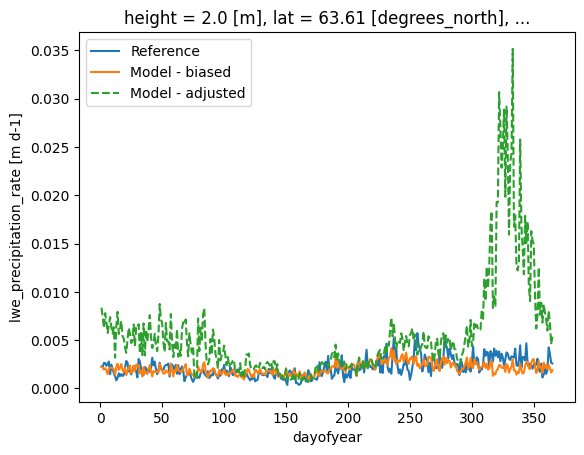

In [16]:
ref.groupby("time.dayofyear").mean().plot(label="Reference")
units.convert_units_to(proj.groupby("time.dayofyear").mean(), "m / d").plot(
    label="Model - biased"
)
scen.groupby("time.dayofyear").mean().plot(label="Model - adjusted", linestyle="--")

plt.legend()

There is something weird going on here! Averaged adjusted data is upwards of ~10x highger than reference data. We can't necessarily expect that adjusted projected data is close to reference, since it of course things will be different in the future. But this has and air of possible over-correction..

For eaxmple, the maximum adjusted precip value is:

In [17]:
scen.values.max()

0.48141891726616437

Half a meter of rain in a day?

The maximum unadjusted value is 10x smaller:


In [18]:
units.convert_units_to(proj, "m d-1").values.max()

0.05475744437717367

And the maximum reference value:

In [19]:
ref.values.max()

0.048606947

Let's look at some pixel averages:

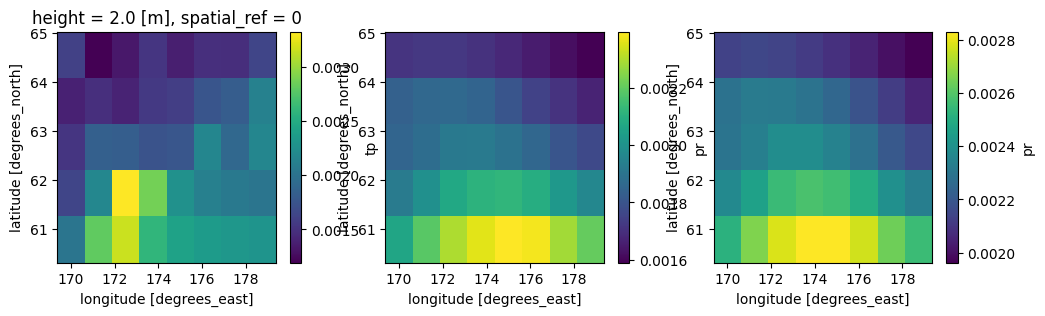

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
sel_di = dict(lon=slice(170, 178.8), lat=slice(60, 65))
ref_ds.sel(sel_di).tp.mean(axis=0).plot(ax=axes[0])
units.convert_units_to(hist_ds.sel(sel_di).pr, "m d-1").mean(axis=0).plot(ax=axes[1])
units.convert_units_to(proj_ds.sel(sel_di).pr, "m d-1").mean(axis=0).plot(ax=axes[2])

The modeled and reference data don't appear to be alarmingly different, with higher pixel averages being ~0.003 m d-1.

Could it have to do with the jitter step? Check out the results if that is omitted:

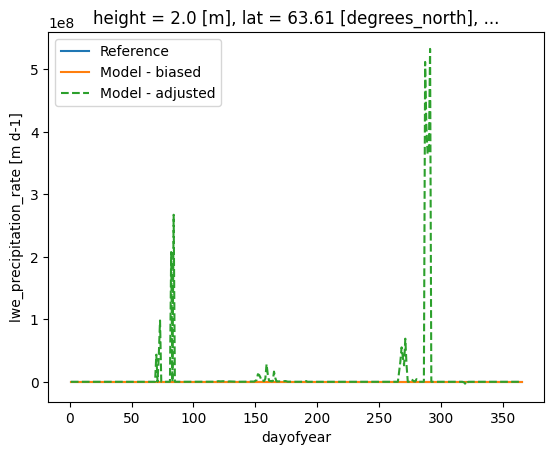

In [21]:
sel_di = dict(lat=bad_lat, lon=bad_lon)
ref = ref_ds["tp"].sel(sel_di, method="nearest")
hist = hist_ds["pr"].sel(sel_di, method="nearest")
proj = proj_ds["pr"].sel(sel_di, method="nearest")
ref.data = ref.data.rechunk({0: -1})
hist.data = hist.data.rechunk({0: -1})
proj.data = proj.data.rechunk({0: -1})

ref.attrs["units"] = "m d-1"

dqm = sdba.DetrendedQuantileMapping.train(
    ref,
    hist,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")
scen = dqm.adjust(proj, extrapolation="constant", interp="nearest", detrend=det)

ref.groupby("time.dayofyear").mean().plot(label="Reference")
units.convert_units_to(proj.groupby("time.dayofyear").mean(), "m d-1").plot(
    label="Model - biased"
)
scen.groupby("time.dayofyear").mean().plot(label="Model - adjusted", linestyle="--")

plt.legend()

Well that is just further confirmation that we need the low-end jitter!

What if we plot the adjusted historical data - are we seeing the same large discrepancy between adjusted and reference?

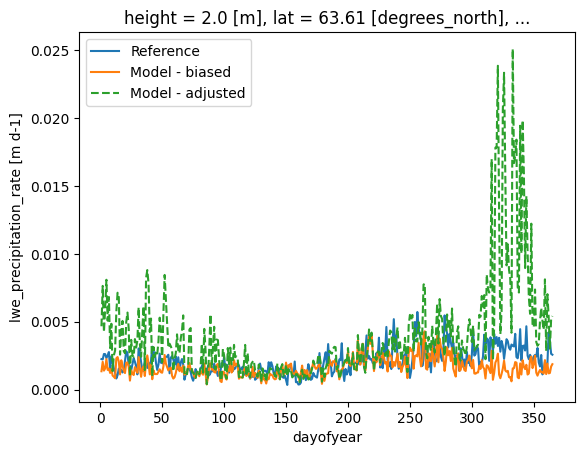

In [22]:
ref = sdba.processing.jitter_under_thresh(ref, thresh="0.01 mm d-1")
hist = sdba.processing.jitter_under_thresh(hist, thresh="0.01 mm d-1")

dqm = sdba.DetrendedQuantileMapping.train(
    ref,
    hist,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")
scen = dqm.adjust(
    hist, extrapolation="constant", interp="nearest", detrend=det
).compute()

ref.groupby("time.dayofyear").mean().plot(label="Reference")
units.convert_units_to(hist.groupby("time.dayofyear").mean(), "m d-1").plot(
    label="Model - biased"
)
scen.groupby("time.dayofyear").mean().plot(label="Model - adjusted", linestyle="--")

plt.legend()

Kinda seeing the same thing, again with adjusted average values being ~10x larger than reference in some areas, like an overcorrection. I wonder if this is happening for other nearby pixels. Let's iterate and plot a sample for an 8x8 section around that area:

In [23]:
sel_di = dict(lon=slice(170, 180), lat=slice(57.5, 65))
ref = ref_ds["tp"].sel(sel_di)
hist = hist_ds["pr"].sel(sel_di)
proj = proj_ds["pr"].sel(sel_di)
ref.data = ref.data.rechunk({0: -1})
hist.data = hist.data.rechunk({0: -1})
proj.data = proj.data.rechunk({0: -1})

ref.attrs["units"] = "m d-1"

ref = sdba.processing.jitter_under_thresh(ref, thresh="0.01 mm d-1")
hist = sdba.processing.jitter_under_thresh(hist, thresh="0.01 mm d-1")

dqm = sdba.DetrendedQuantileMapping.train(
    ref,
    hist,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")
scen = dqm.adjust(
    proj, extrapolation="constant", interp="nearest", detrend=det
).compute()

In [24]:
ref_mean_doy = ref.groupby("time.dayofyear").mean()
proj_mean_doy = units.convert_units_to(proj.groupby("time.dayofyear").mean(), "m d-1")
scen_mean_doy = scen.groupby("time.dayofyear").mean()

Plot along a diagonal cross section of the adjusted data:

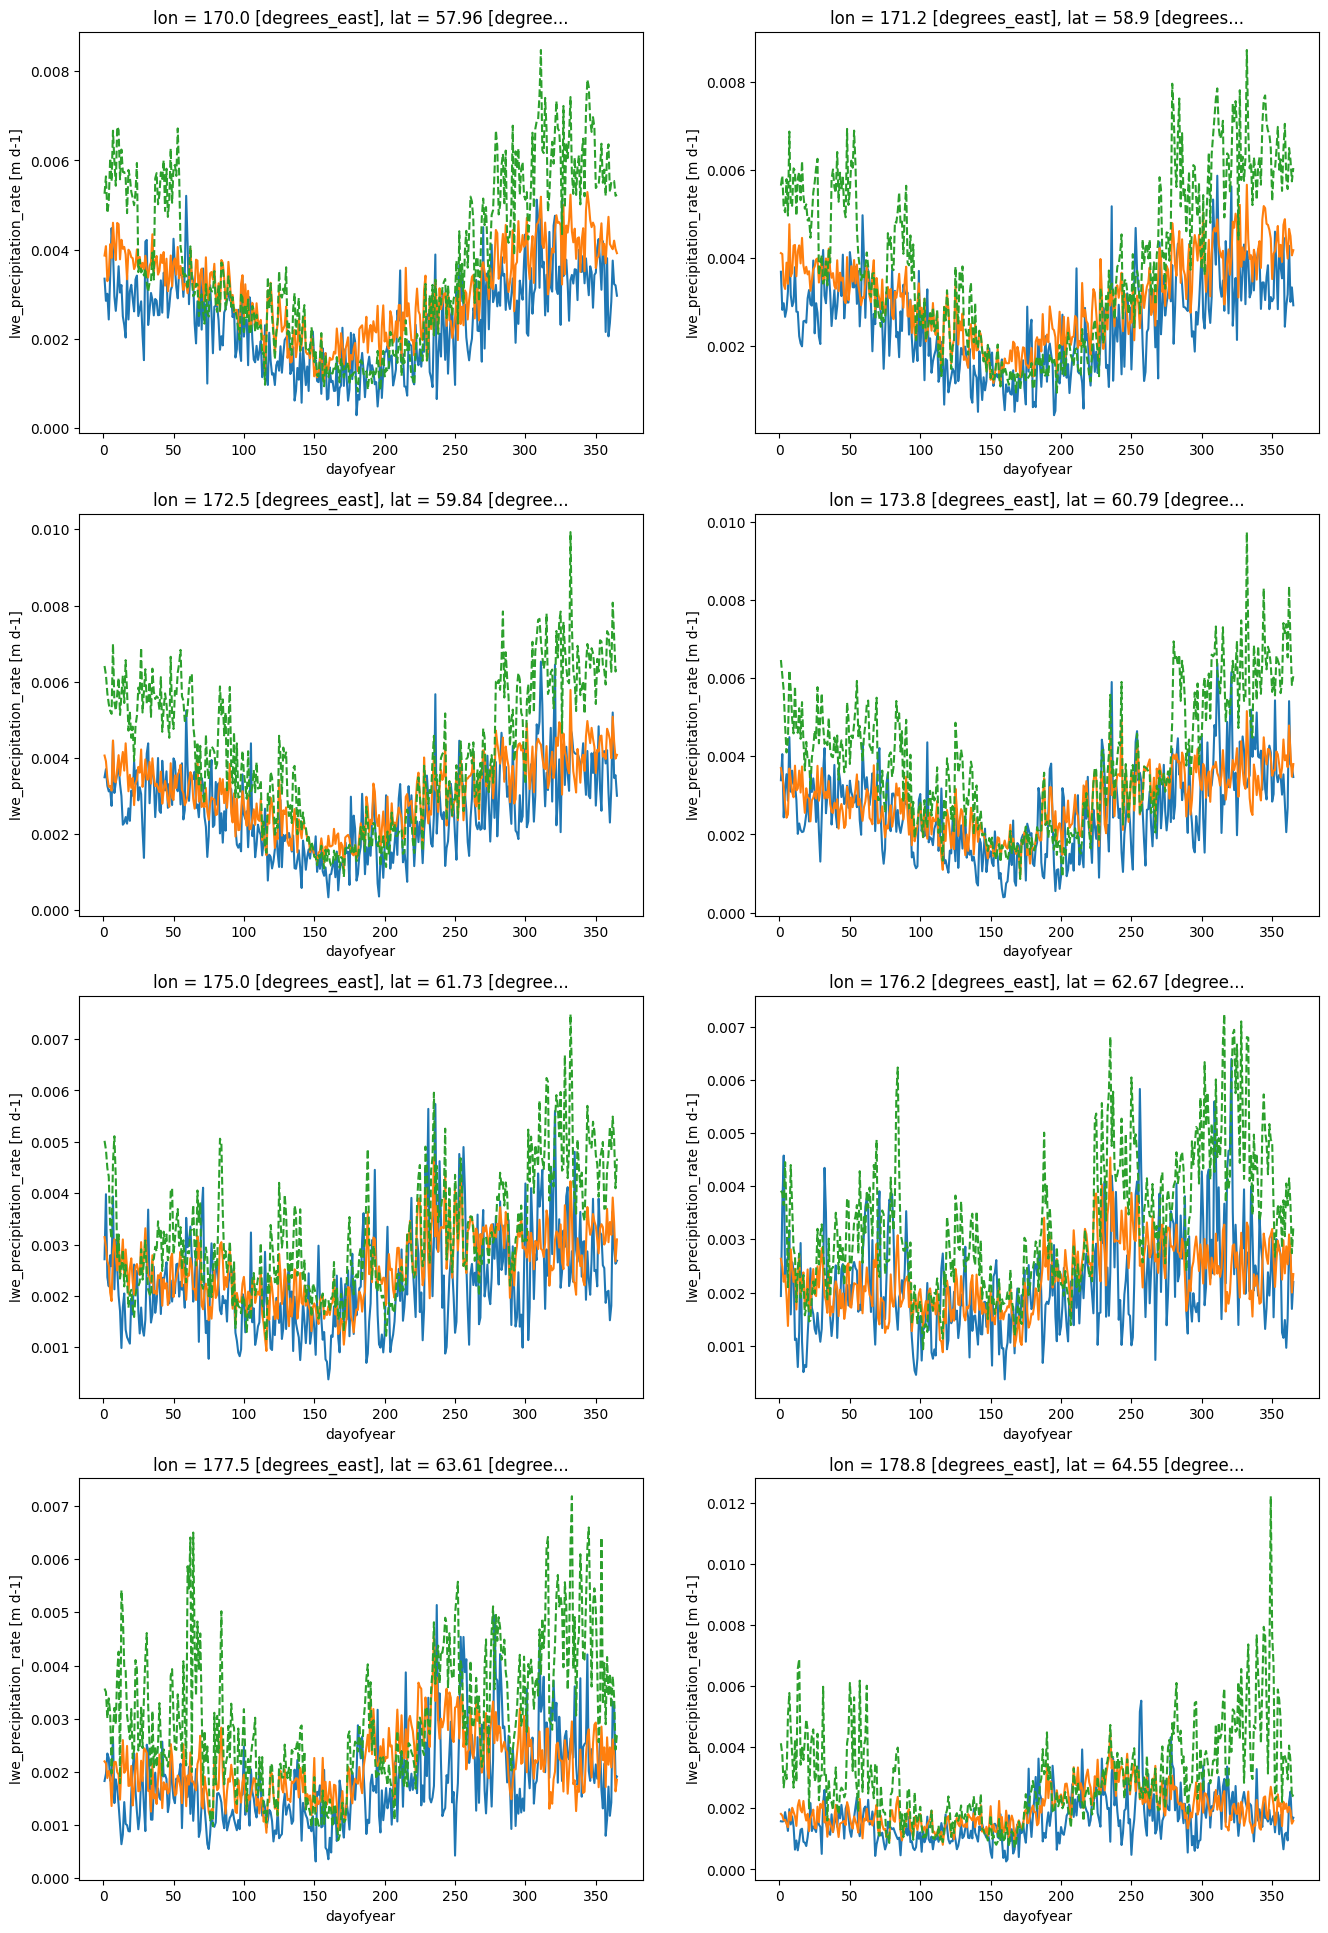

In [25]:
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
for lat, lon, ax in zip(
    ref_mean_doy.lat.values, ref_mean_doy.lon.values, axes.flatten()
):
    sel_di = dict(lat=lat, lon=lon)
    ref_mean_doy.sel(sel_di).plot(label="Reference", ax=ax)
    proj_mean_doy.sel(sel_di).plot(label="Model - biased", ax=ax)
    scen_mean_doy.sel(sel_di).plot(label="Model - adjustedsed", linestyle="--", ax=ax)

Huh. I guess I wonder if this happens with other models, in the same place? 
Here is the same adjustment and plots for GFDL-ESM4, ssp585:

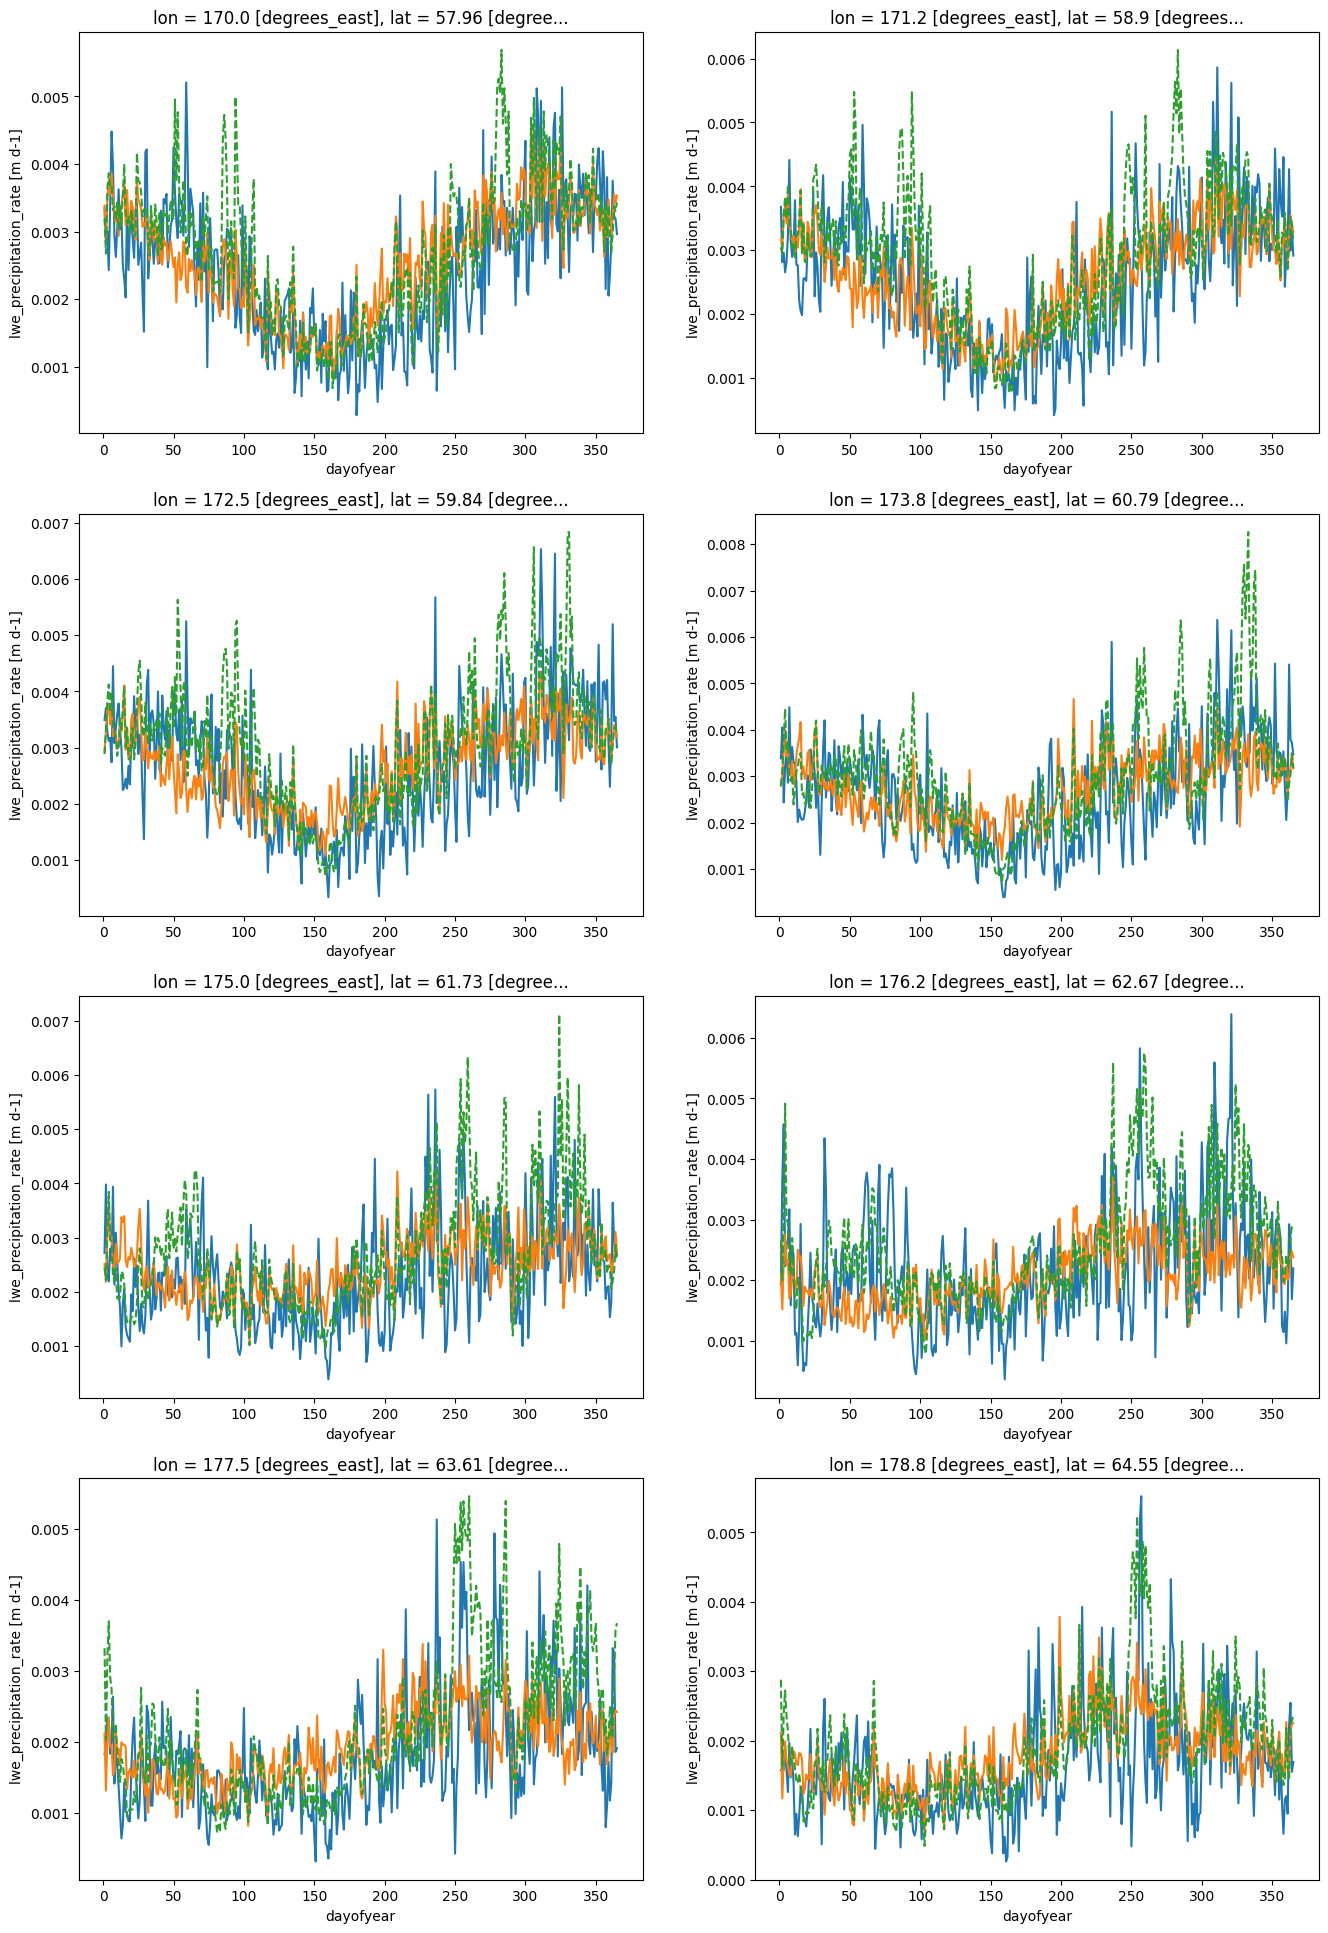

In [26]:
model = "GFDL-ESM4"

hist_fps = [
    cmip6_dir.joinpath(
        model,
        "historical",
        "day",
        var_id,
        cmip6_tmp_fn.format(
            var_id=var_id, model=model, scenario="historical", year=year
        ),
    )
    for year in range(hist_start_year, hist_end_year + 1)
]

scenario = "ssp585"
sim_ref_fps = [
    cmip6_dir.joinpath(
        model,
        scenario,
        "day",
        var_id,
        cmip6_tmp_fn.format(var_id=var_id, model=model, scenario=scenario, year=year),
    )
    for year in range(sim_ref_start_year, sim_ref_end_year + 1)
]

# get all remaining projected files
sim_end_year = 2100
sim_fps = [
    cmip6_dir.joinpath(
        model,
        scenario,
        "day",
        var_id,
        cmip6_tmp_fn.format(var_id=var_id, model=model, scenario=scenario, year=year),
    )
    for year in range(sim_ref_start_year, sim_end_year + 1)
]

hist_ds = xr.open_mfdataset(hist_fps + sim_ref_fps)
proj_ds = xr.open_mfdataset(sim_fps)

sel_di = dict(lon=slice(170, 180), lat=slice(57.5, 65))

hist = hist_ds["pr"].sel(sel_di)
proj = proj_ds["pr"].sel(sel_di)
hist.data = hist.data.rechunk({0: -1})
proj.data = proj.data.rechunk({0: -1})

hist = sdba.processing.jitter_under_thresh(hist, thresh="0.01 mm d-1")

dqm = sdba.DetrendedQuantileMapping.train(
    ref,
    hist,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind="*",
    adapt_freq_thresh="1 mm d-1",
)

# Create the detrending object
det = LoessDetrend(group="time.dayofyear", d=0, niter=1, f=0.2, weights="tricube")
scen = dqm.adjust(
    proj, extrapolation="constant", interp="nearest", detrend=det
).compute()

proj_mean_doy = units.convert_units_to(proj.groupby("time.dayofyear").mean(), "m d-1")
scen_mean_doy = scen.groupby("time.dayofyear").mean()

fig, axes = plt.subplots(4, 2, figsize=(16, 24))
for lat, lon, ax in zip(
    ref_mean_doy.lat.values, ref_mean_doy.lon.values, axes.flatten()
):
    sel_di = dict(lat=lat, lon=lon)
    ref_mean_doy.sel(sel_di).plot(label="Reference", ax=ax)
    proj_mean_doy.sel(sel_di).plot(label="Model - biased", ax=ax)
    scen_mean_doy.sel(sel_di).plot(label="Model - adjustedsed", linestyle="--", ax=ax)

That seems a little better, in that it is more difficult to tell :) let's look at monthly means:

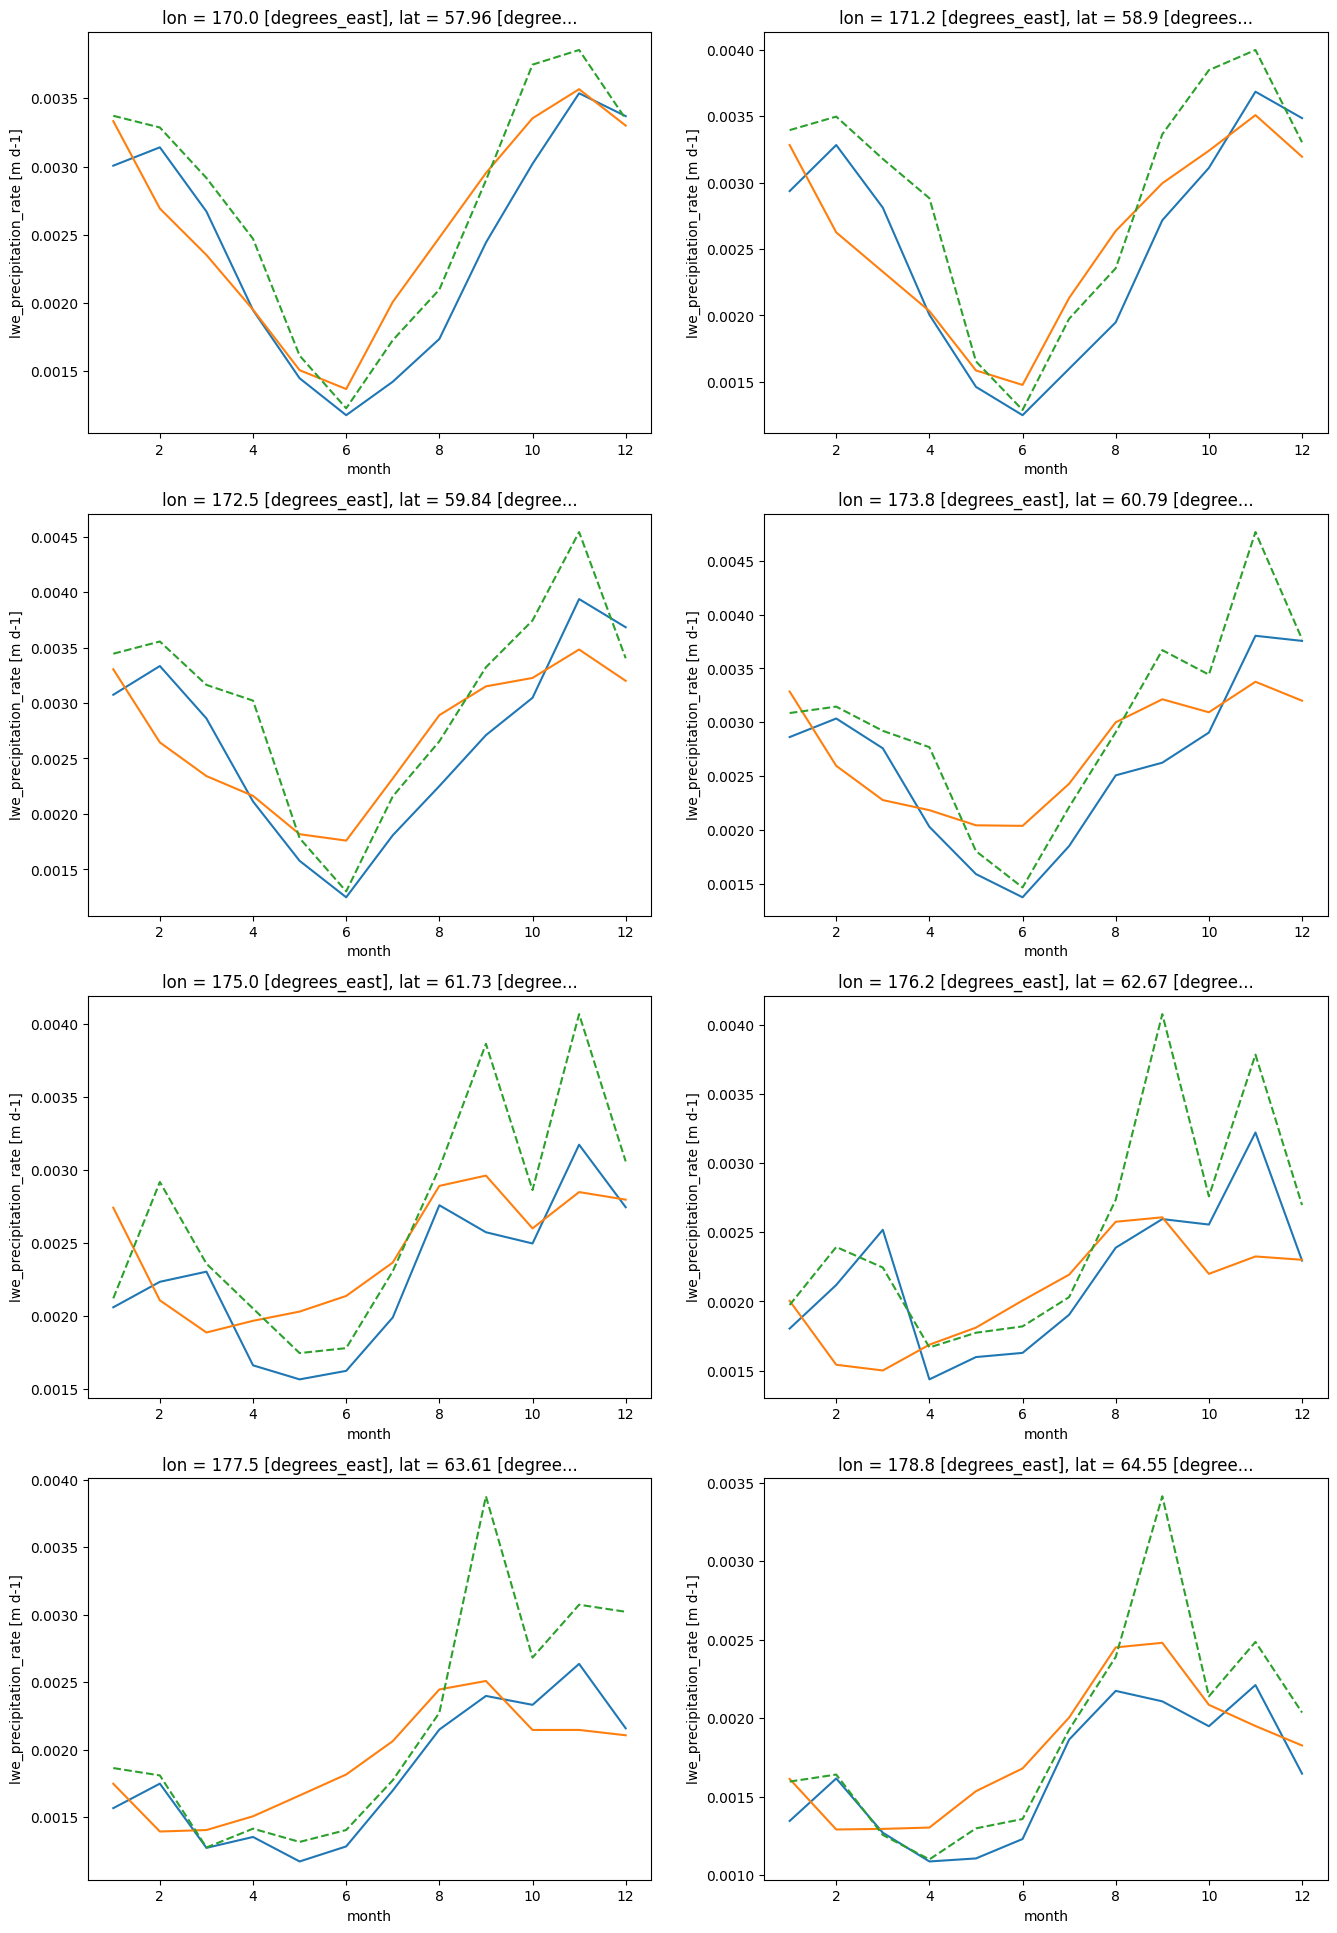

In [27]:
ref_mean_mo = ref.groupby("time.month").mean()
proj_mean_mo = units.convert_units_to(proj.groupby("time.month").mean(), "m d-1")
scen_mean_mo = scen.groupby("time.month").mean()

fig, axes = plt.subplots(4, 2, figsize=(16, 24))
for lat, lon, ax in zip(ref_mean_mo.lat.values, ref_mean_mo.lon.values, axes.flatten()):
    sel_di = dict(lat=lat, lon=lon)
    ref_mean_mo.sel(sel_di).plot(label="Reference", ax=ax)
    proj_mean_mo.sel(sel_di).plot(label="Model - biased", ax=ax)
    scen_mean_mo.sel(sel_di).plot(label="Model - adjustedsed", linestyle="--", ax=ax)

Well it seems like things aren't really off by an order of magnitude at least. 

In [28]:
scen.values.max()

0.16729527430080823

And the maximum adjusted value is at least not too crazy, at 167 mm in one day. Perhaps there is something to do with the MIROC model. Should probably do more investigation into this, but perhaps from the QC / evaluation side of things, as there will probably be more weird issue like this that it's probably best to just identify and move on. 